# Fractional Brownian motion

In [1]:
import warnings
warnings.filterwarnings('ignore')

#sets the notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# conda install matplotlib path scipy statsmodels seaborn 

In [3]:
# pip install palettable tqdm

In [2]:
# Standard Libraries
import sys
import os
import path

# Third party libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from scipy.stats import norm

# Figures
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker
import palettable
import seaborn as sns
from string import ascii_lowercase

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=True):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['sans-serif'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'on',
    'xtick.top': 'on',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': True,
    'axes.spines.top': True}

    mpl.rcParams.update(rcparams) 
    mpl.rcParams['lines.linewidth'] = 5
    mpl.rcParams['pdf.fonttype'] = 42 

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def label_panels(axs,xy=(0.05, 0.9),labels=None):
    if labels==None:
        labels=['('+l+')' for l in ascii_lowercase]
    for i,ax in enumerate(axs.flatten()):
        ax.annotate(labels[i],xy=xy, xycoords="axes fraction",fontsize=30)

In [3]:
from combmodel import *

# Generating the noise

In [4]:
generate_noise(hurstx=0.5,hursty=0.5,tmax=5)

(array([ 1.26521119,  0.07802809, -0.85018802,  0.22263325,  2.37645126,
        -0.42331667]),
 array([ 0.01213585, -0.21750191,  0.41339667, -0.0704064 , -1.06065616,
         0.33448503]))

In [5]:
generate_noise(hurstx=0.5,hursty=0.99,tmax=5)

(array([ 1.08068459,  0.9842089 , -1.24363049, -0.23969282, -0.69328341,
        -0.18936375]),
 array([-0.52220465, -0.79047896, -0.66791731, -0.62984898, -0.47475796,
        -0.83894718]))

# Trajectory example

In [6]:
langevin_fbn(x0=0,y0=0,betax=1,betay=1,hurstx=0.05,hursty=0.95,tmax=10,disable_tqdm=True)

(array([0.        , 0.44701469, 0.2611705 , 0.38700642, 1.27014466,
        1.63133828, 1.052508  , 1.10960267, 0.42722851, 1.47981553]),
 array([ 0.        , -0.39253457, -0.75375366, -2.1913192 , -2.4070281 ,
        -1.73514062, -1.29280092, -1.37838616, -1.93232252, -1.94106641]))

Text(0, 0.5, 'Position, $y(t)$')

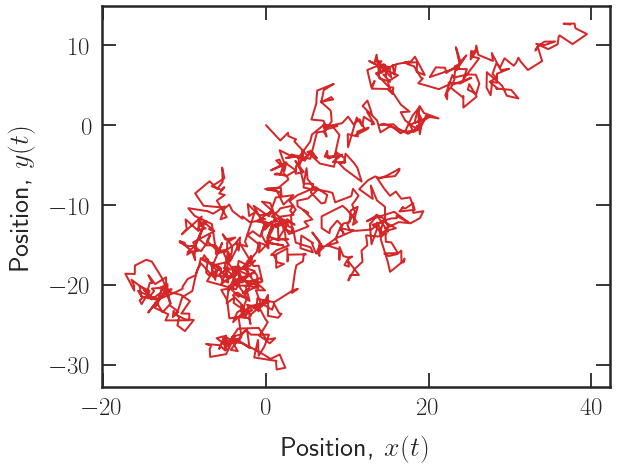

In [7]:
x,y=langevin_fbn(x0=0,y0=0,betax=1,betay=1,hurstx=0.5,hursty=0.5,tmax=1000,disable_tqdm=True)
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(9.1,7))
ax.plot(x,y,color='#D62728',markersize=0,linewidth=2)
ax.set_xlabel(r'Position, $x(t)$')
ax.set_ylabel(r'Position, $y(t)$')

# Generate ensemble

In [8]:
x0,y0=0,0

x_plane=[]
y_plane=[]
for i in tqdm(range(0,10**3)):
    xi,yi=langevin_fbn(0,0,0.1,0.1,0.5,0.5,10**4,disable_tqdm=True)
    x_plane.append(xi)
    y_plane.append(yi)
x_plane=np.array(x_plane)
y_plane=np.array(y_plane)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 141.51it/s]


# MSD

In [9]:
import statsmodels.api as sm
from scipy.stats import norm
from scipy import stats

def power_law_fit(x,y):
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    return results.params

def power_law_function(x,params):
    return np.exp(params[0])*x**params[1]

In [10]:
t=np.arange(0,len(x_plane[0]))[:]
variance_x=np.var(x_plane,axis=0)[:]
variance_y=np.var(y_plane,axis=0)[:]
params_x=power_law_fit(np.log(t)[1:10**2],np.log(variance_x)[1:10**2]) 
params_y=power_law_fit(np.log(t)[1:10**2],np.log(variance_y)[1:10**2])
print(params_x,params_y)

[-4.5358384   0.98991777] [-4.62353202  1.00827176]


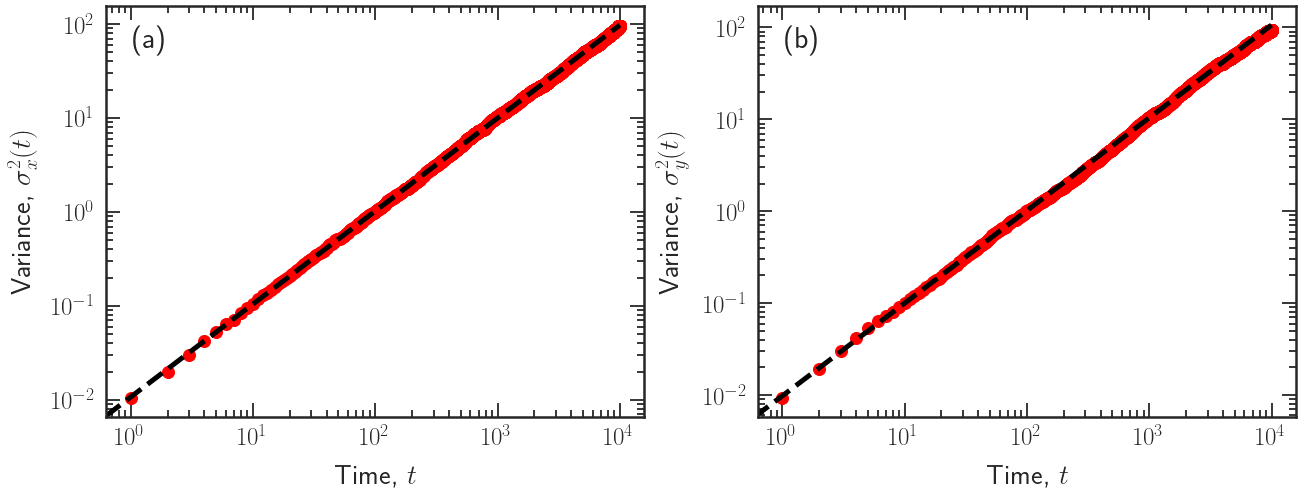

In [11]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nx=2, ny=1, scale=1))

ax=axs.flatten()[0]
   
ax.loglog(t,variance_x,'o',color='red',markersize=12)
ax.loglog(t,power_law_function(t,params_x),'k--')
ax.set_ylabel(r'Variance, $\sigma_x^2(t)$')
ax.set_xlabel(r'Time, $t$')

ax=axs.flatten()[1]
   
ax.loglog(t,variance_y,'o',color='red',markersize=12)
ax.loglog(t,power_law_function(t,params_y),'k--')

ax.set_ylabel(r'Variance, $\sigma_y^2(t)$')
ax.set_xlabel(r'Time, $t$')
label_panels(axs)
plt.tight_layout()

# Marginal distributions

In [15]:
def normalize(x,y):
    return (x-np.mean(x,axis=0))/np.std(x,axis=0),(y-np.mean(y,axis=0))/np.std(y,axis=0)

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def pdf(data, nbins=30, log=False, symmetrical=False):
    if not isinstance(nbins, str):
        if log:
            if symmetrical:
                maxdata = max(np.abs(np.min(data)), np.abs(np.max(data)))
                bins = np.logspace(-maxdata, maxdata, nbins)
            else:
                bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), nbins)
        else:
            if symmetrical:
                maxdata = max(np.abs(np.min(data)), np.abs(np.max(data)))
                bins = np.linspace(-maxdata, maxdata, nbins)
            else:
                bins = np.linspace(np.min(data), np.max(data), nbins)
    else:
        bins = nbins
    densities, bbins = np.histogram(data, bins=bins, density=True)
    return moving_average(bbins, 2), densities

In [16]:
normalized_x,normalized_y=normalize(x_plane,y_plane)

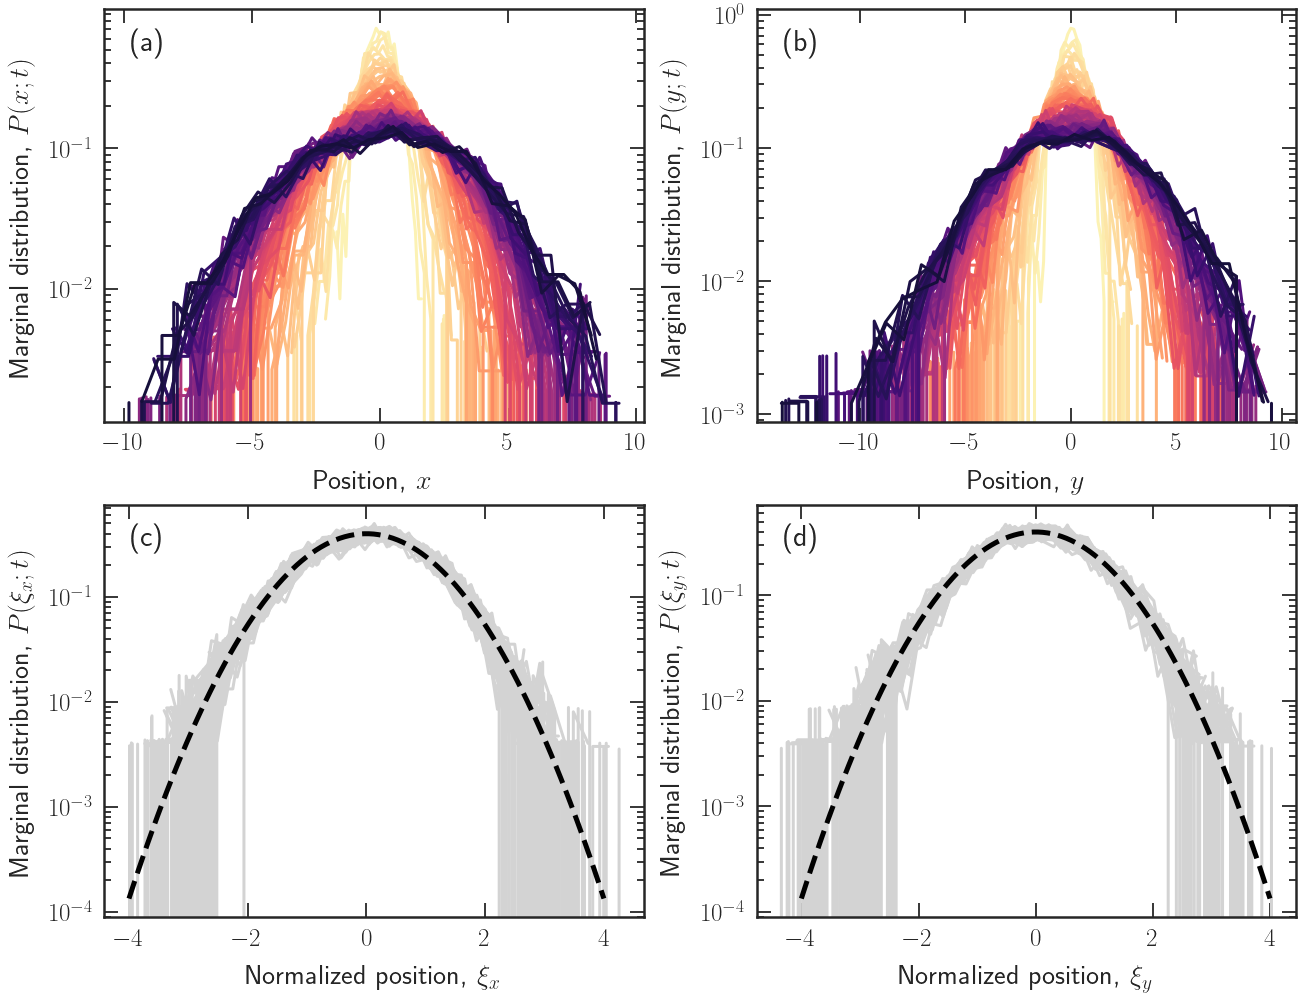

In [17]:
t_interval=10
t_min=30
t_max=1000
colormap = plt.cm.magma_r
colors=[colormap(i) for i in np.linspace(0, 0.9,t_max)]

f, axs = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(nx=2, ny=2, scale=1))

ax=axs.flatten()[0]
for t in range(t_min,t_max,t_interval):
    bins,densities=pdf(x_plane[::,t])
    ax.plot(bins,densities,color=colors[t],linewidth=3,)

ax.set_yscale('log')
ax.set_xlabel(r'Position, $x$')
ax.set_ylabel(r'Marginal distribution, $P(x;t)$')

ax=axs.flatten()[1]
   
for t in range(t_min,t_max,t_interval):
    bins,densities=pdf(y_plane[::,t])
    ax.plot(bins,densities,color=colors[t],linewidth=3)
    
ax.set_yscale('log')
ax.set_xlabel(r'Position, $y$')
ax.set_ylabel(r'Marginal distribution, $P(y;t)$')

ax=axs.flatten()[2]
   
for t in range(t_min,t_max,t_interval):
    bins,densities=pdf(normalized_x[::,t])
    ax.plot(bins,densities,color='lightgray',linewidth=3)

r = np.linspace(-4.,4., 100)
ax.plot(r, stats.norm.pdf(r, 0, 1),'k--')

ax.set_yscale('log')
ax.set_xlabel(r'Normalized position, $\xi_x$')
ax.set_ylabel(r'Marginal distribution, $P(\xi_x;t)$')

ax=axs.flatten()[3]
for t in range(t_min,t_max,t_interval):
    bins,densities=pdf(normalized_y[::,t])
    ax.plot(bins,densities,color='lightgray',linewidth=3)

r = np.linspace(-4.,4., 100)
ax.plot(r, stats.norm.pdf(r,0,1),'k--')
ax.set_yscale('log')
ax.set_xlabel(r'Normalized position, $\xi_y$')
ax.set_ylabel(r'Marginal distribution, $P(\xi_y;t)$')

label_panels(axs)
f.tight_layout()


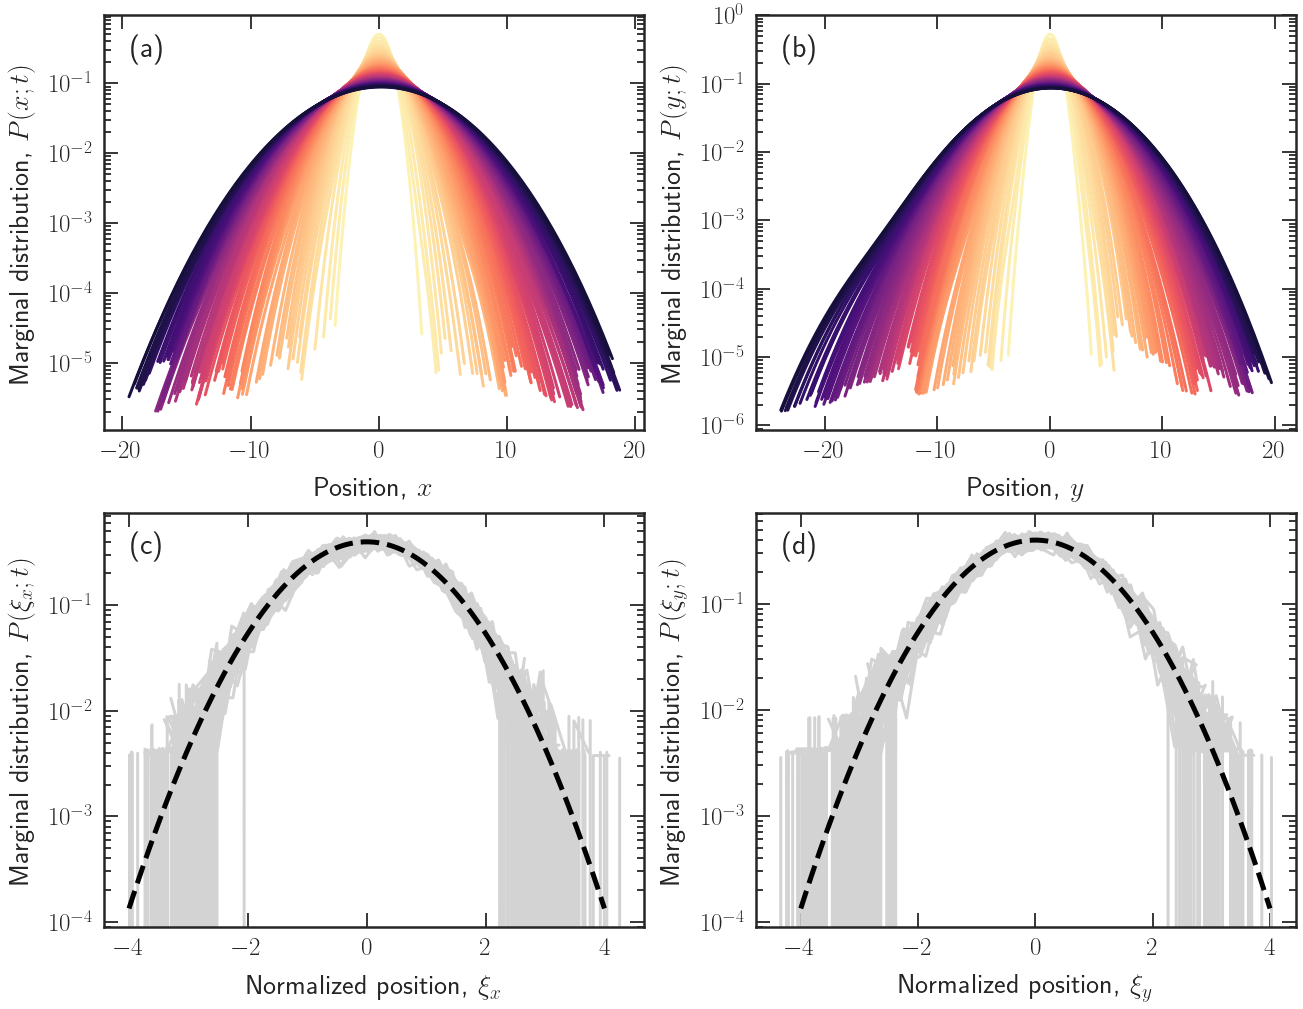

In [18]:
t_interval=10
t_min=30
t_max=1000
bw=1
colormap = plt.cm.magma_r
colors=[colormap(i) for i in np.linspace(0, 0.9,t_max)]

f, axs = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(nx=2, ny=2, scale=1))

ax=axs.flatten()[0]
for t in range(t_min,t_max,t_interval):
    sns.kdeplot(x_plane[::,t],ax=ax,color=colors[t],linewidth=3,bw=bw)

ax.set_yscale('log')
ax.set_xlabel(r'Position, $x$')
ax.set_ylabel(r'Marginal distribution, $P(x;t)$')

ax=axs.flatten()[1]
   
for t in range(t_min,t_max,t_interval):
    sns.kdeplot(y_plane[::,t],ax=ax,color=colors[t],linewidth=3,bw=bw)
    
ax.set_yscale('log')
ax.set_xlabel(r'Position, $y$')
ax.set_ylabel(r'Marginal distribution, $P(y;t)$')

ax=axs.flatten()[2]
   
for t in range(t_min,t_max,t_interval):
    bins,densities=pdf(normalized_x[::,t])
    ax.plot(bins,densities,color='lightgray',linewidth=3)

r = np.linspace(-4.,4., 100)
ax.plot(r, stats.norm.pdf(r, 0, 1),'k--')

ax.set_yscale('log')
ax.set_xlabel(r'Normalized position, $\xi_x$')
ax.set_ylabel(r'Marginal distribution, $P(\xi_x;t)$')

ax=axs.flatten()[3]
for t in range(t_min,t_max,t_interval):
    bins,densities=pdf(normalized_y[::,t])
    ax.plot(bins,densities,color='lightgray',linewidth=3)


r = np.linspace(-4.,4., 100)
ax.plot(r, stats.norm.pdf(r,0,1),'k--')
ax.set_yscale('log')
ax.set_xlabel(r'Normalized position, $\xi_y$')
ax.set_ylabel(r'Marginal distribution, $P(\xi_y;t)$')

label_panels(axs)
f.tight_layout()


In [22]:
# pip install watermark

In [23]:
import watermark
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Apr 11 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.2.0

watermark  : 2.3.0
sys        : 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:45:10) [Clang 12.0.1 ]
matplotlib : 3.5.1
pandas     : 1.4.2
palettable : 3.3.0
path       : 16.4.0
seaborn    : 0.11.2
scipy      : 1.8.0
numpy      : 1.22.3
statsmodels: 0.13.2

Watermark: 2.3.0

